<h2> Solving the CSP with 

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import random
import operator
import copy
import math
import itertools
import time

In [2]:
#Assignment problem
s_types = 5
s_lens = [120, 115, 110, 105, 100]
s_costs = [12, 11.5, 11, 10.5, 10]

p_types = 36
p_lens = [21, 22, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 38, 39, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63, 65, 66, 67]
p_quants = [13, 15, 7, 5, 9, 9, 3, 15, 18, 17, 4, 17, 20, 9, 4, 19, 4, 12, 15, 3, 20, 14, 15, 6, 4, 7, 5, 19, 19, 6, 3, 7, 20, 5, 10, 17]

In [3]:
#Sort stock
stock_info = zip(s_lens, s_costs)
sorted_stock_info = sorted(stock_info)
s_costs = [x for _, x in sorted_stock_info]
list.sort(s_lens)

#Sort units
stock_info = zip(p_lens, p_quants)
sorted_stock_info = sorted(stock_info)
p_quants = [x for _, x in sorted_stock_info]
list.sort(p_lens)

In [16]:
#Generate the unique units
units = []
for x in range(p_types):
    for _ in range(p_quants[x]):
        units.append(p_lens[x])
list.sort(units)
units

[21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 42,
 42,
 42,
 42,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 45,
 45,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,


In [5]:
class Organism:

    def __init__(self):
        #Remaining values
        self.units  = units.copy()
        self.stocks = []
        self.waste = []
        
        random.shuffle(self.units)

        self.update_cuts()
        self.update_stocks()
        self.update_cost()
                    
    
    def update_cuts(self):
        #Each number represents the last piece index in a group
        self.cut_at = [-1]
        #The highest number of pieces in the a group
        while self.cut_at[-1] != len(self.units)-1:
            #Get the highest possible pieces in a group
            upper_limit = math.floor(s_lens[-1]/p_lens[0])
            group = 0
            start = self.cut_at[-1]+1
            
            if start+upper_limit > len(self.units)-1:
                end = len(self.units) - start
            else:
                end = upper_limit

            possible_groups = []
            group_lens = []
            #Get the lengths of the combination with the next k units
            for x in range(end):
                possible_groups.append([])
                for j in range(x+1):
                    pos = start+j
                    possible_groups[x].append(self.units[pos]) 
                group_lens.append(sum(possible_groups[x]))
                
                if group_lens[-1]> s_lens[-1]:
                    del group_lens[-1]
                    break
                    
            #Add the largest cut with the lowest waste
            best = 0
            for x in range(len(group_lens)):
                for y in range(s_types):
                    if group_lens[x] <= s_lens[y]:
                        self.stocks.append(y)
                        diff = s_lens[y] - group_lens[x]
                        if diff >= best:
                            best = x
                        break
            
            index = start+best
            
            #If we reach the end of pieces add the final index
            if index > len(self.units):
                self.cut_at.append(len(self.units)-1)
                break
            else:
                 self.cut_at.append(index)

        del self.cut_at[0]
    
    #Get the total cost of all stocks used
    def update_cost(self):
        self.cost = 0
        for x in range(len(self.stocks)):
            i = self.stocks[x]
            self.cost = self.cost + s_costs[i]

    def update_stocks(self):
        self.stocks = []
        self.waste = []
        #Record the stock that provides the smallest waste to a cut
        for x in range(len(self.cut_at)):
            if x == 0:
                e = self.cut_at[x]+1
                group = self.units[0:e]
            else:
                s = self.cut_at[x-1]+1
                e = self.cut_at[x]+1
                group = self.units[s:e] 
            for y in range(s_types):
                if sum(group) <= s_lens[y]:
                    self.stocks.append(y)
                    waste = s_lens[y]-sum(group)
                    self.waste.append(waste)
                    break
        #Get the total waste of all cuts
        self.total_waste = sum(self.waste)             

    def ThreePS(self, t = 1):
        for _ in range(t):
            
            #Unit index and value
            slt_idx = [random.randint(0,len(self.units)-1)]   
            slt_val = []

            #Get the sqaure root inverse sum of all waste
            p_sum= 0
            for x in range(len(self.waste)):
                if self.waste[x]!=0:
                    p_sum = p_sum + self.waste[x]

            #Get the probability of indiviual waste
            p = []
            for x in range(len(self.waste)):
                if self.waste[x]!=0:
                    p.append(self.waste[x]/p_sum)
                else:
                    p.append(0)

            clt = 0
            stop_mutation = False
            while clt <2:
                i = random.uniform(0,1)
                #Select a random stock index to use based on the stock probabilities
                k = 0
                for x in range(len(p)):
                    k = k + p[x]
                    if k >= i:
                        pos = x
                        break
                #if all the probabilities equal 0 or the probablity of a single stock is 1 then stop the mutation        
                if k == 0:
                    stop_mutation = True
                    clt = clt+1
                    break
                    
                for x in range(len(p)):
                    if p[x] == 1:
                        stop_mutation = True
                        
                        clt = clt+1
                        break
                #Get random unit in stock choosen
                if pos == 0:
                    s = 0
                    e = self.cut_at[pos]+1
                    options = self.units[s:e]
                else:
                    s = self.cut_at[pos-1]+1
                    e = self.cut_at[pos]+1
                    options = self.units[s:e]
                

                j = random.randint(0,len(options)-1)

                i = j+s
                #Make sure the unit index hasnt already been choosen
                if i not in slt_idx:
                    slt_idx.append(i)
                    clt = clt+1
                #Get the values for each unit choosen
            for x in range(len(slt_idx)):
                slt_val.append(self.units[slt_idx[x]])
            
            #Do the 3 Piece Swap; A swaps with B, then B swap with C, ABC becomes CAB
            if stop_mutation == False:
                self.units[slt_idx[0]] = slt_val[1]
                self.units[slt_idx[1]] = slt_val[0]

                self.units[slt_idx[0]] = slt_val[2]
                self.units[slt_idx[2]] = slt_val[1]
                
                self.update_cuts()
                self.update_stocks()
                self.update_cost()
        

In [6]:
def evolution():
    best = []
    population = []
    parents = []
    size = 20
    opponents = 10
    generations = 1000
    
    #Initlise the organisms and sort them
    for x in range(size):
        population.append(Organism())
        
    #Loop for each generation
    for x in range(generations):
        if (x+1)%250==0:
            print("Generation",x+1)
        
        #loop through the population
        for x in range(size):
            
            new = copy.deepcopy(population[x])
            new.ThreePS(2)
            population.append(new)
        
        wins = []
        
        for x in range(len(population)):
            wins.append([x,0])
            #Select opponents
            data = [i for i in range(0,size*2)]
            data.remove(x)
            random.shuffle(data)

            opp = data[0:opponents]
            #Have the organism complete with each opponent with attribute cost and record all their wins
            for y in range(opponents):
                a = population[opp[y]].total_waste
                b = population[x].total_waste
                
                if a > b:
                    wins[x][1] = wins[x][1]+1
        
        #Sort the population by wins
        wins.sort(key=lambda x:x[1],reverse=True)
        
        new_pop = []
        #Take the best organisms equal to population size
        for x in range(size):
            index = wins[x][0]
            new_pop.append(population[index])
            
        population = new_pop

        #Sort the population in order of best solutions and record the lowest cost for this generation
        population.sort(key=operator.attrgetter('total_waste'))
        best.append(population[0].total_waste)
    
    #return the population and lowest cost from each generation
    return population, best

In [11]:
#Run algorithm
t_start = time.time()
pop, best = evolution()
print(np.round(time.time() - t_start, 2))

Generation 250
Generation 500
Generation 750
Generation 1000
58.66


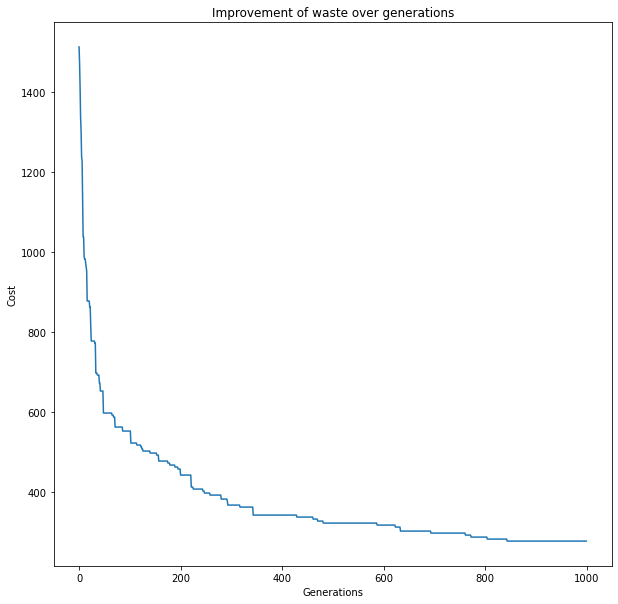

In [12]:
plt.figure(figsize=[10,10])
plt.title("Improvement of waste over generations")
plt.ylabel('Cost')
plt.xlabel('Generations')
plt.plot(best)

In [13]:
pop[0].cost

1791.0

In [14]:
pop[0].total_waste

277

In [15]:
pop[0].waste

[2,
 0,
 0,
 4,
 4,
 3,
 2,
 4,
 2,
 0,
 1,
 3,
 2,
 2,
 5,
 2,
 3,
 3,
 0,
 1,
 0,
 0,
 4,
 2,
 2,
 0,
 1,
 1,
 1,
 5,
 2,
 1,
 3,
 2,
 3,
 1,
 3,
 2,
 1,
 2,
 4,
 2,
 3,
 2,
 1,
 0,
 2,
 0,
 3,
 4,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 4,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 4,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 5,
 5,
 1,
 4,
 3,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 4,
 6,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 4,
 2,
 1,
 1,
 1,
 0,
 6,
 1,
 4,
 1,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 5,
 4,
 2,
 1,
 1,
 0,
 0,
 3,
 5,
 4,
 4,
 1,
 3,
 1,
 3,
 0,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 0,
 1,
 4,
 0,
 0,
 1,
 0,
 1,
 5]